In [92]:
%load_ext autoreload
%autoreload 2

from dynamic_system_functions import *
import casadi as ca
cax = ca.MX
M = cax.sym('M')
B = cax.sym('B')
Kp = cax.sym('Kp')
Kd = cax.sym('Kd')

R = sys([Kd,Kp,0],[M,B,Kp])

D = pade(2.0e-3, 4)

Kl = cax.sym('Kl')
Cff = sys([Kl, 1], [1])

B_real = cax.sym('B_real')
a_vel = cax.sym('a_vel')
P_hat = cax.sym('P_hat')
a_acc = cax.sym('a_acc')
Cfb_Ov = sys([B_real*a_vel, 0],[1, a_vel, 0])
P_hat_Oa = sys([-P_hat*a_acc*a_vel, 0, 0],[1, a_acc+a_vel, a_acc*a_vel, 0])

Ma = cax.sym('Ma')
Ba = cax.sym('Ba')
A = sys([1], [Ma, Ba, 0])

p = [M, B, Kp, Kd] # fixed params
x = [Kl, Ma, Ba, B_real, a_vel, P_hat, a_acc]   # dec variables
vars = [*p, *x]    # list of all the variables, useful for making casadi functions
x_names = [str(v) for v in x]
##### Building some SYSTEMS ######
# OL from F to v
G = R*Cff*A
Gd = R*D*Cff*A
Gd_imag, _ = Gd.get_re_im(vars)

D_fb = sys([1],[1]) + R*Cfb_Ov + G*P_hat_Oa

# Environment contact denominator
K_env = cax.sym('K_env')
M_env = cax.sym('M_env')
E = sys([M_env, 0, K_env], [1, 0])

G_cl = fb(Gd, E)
G_cl_den_fn = ca.Function('G_cl_den_fn', [K_env, M_env, *vars], G_cl.den)

# Noise TFs
# OL noise
noise_area_of_concern = sys([100, 0], [1, 100])
G_nf = Cff*A*noise_area_of_concern
G_nx = (Cfb_Ov + Cff*A*(P_hat_Oa))*noise_area_of_concern
# CL noise
G_nf_cl = Cff*A/(D_fb+Cff*A*E)

#G_nf_num = con(con(con(con(D_num, Cff_num), A_num), E_den), G_den)
#G_nf_den = con(con(con(G_cl_den, D_den), Cff_num), A_num)

nf_norm_fn = ca.Function('nf_norm_fn', [K_env, M_env, *vars], [G_nf.h2_norm()])

[autoreload of dynamic_system_functions failed: Traceback (most recent call last):
  File "/home/hanikevi/.local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/hanikevi/.local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/hanikevi/git/autodiff_dyn_sys/dynamic_system_functions.py", line 124, in <module>
    class lyap(Callback):
NameError: name 'Callback' is not defined
]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Cancelling pole/zero at 0


In [243]:
from dynamic_system_functions import lyap_solver, lyap
ly = lyap_solver('lyapio',2)
A = np.array([[0.1, 1],[1, 3]])
Q = np.eye(2)
B = np.ones((2,2))
X = ly(A, B)
#print(X)
X = lyap(A, B)
#print(X)

As = ca.MX.sym('As',2,2)
Qs = ca.MX.sym('Qs',2,2)
A2s = ca.MX.sym('As',2,2)
Q2s = ca.MX.sym('Qs',2,2)
Ps = ca.MX.sym('Ps',2,2)
fseeds = [ca.MX.sym("f",2,2) for i in range(ly.n_in())]
aseeds = [ca.MX.sym("a",2,2)  for i in range(ly.n_out())]
res = ly.call([As, Qs], True)
res_ca = lyap(As, Qs)
print(res_ca)

[rev] = ca.reverse(res, [As, Qs, Ps, A2s, Q2s], [aseeds], {})
[rev_ca] = ca.reverse([res_ca], [As, Qs, Ps, A2s, Q2s], [aseeds], {})

[fwd] = ca.forward(res, [As, Qs], [fseeds], {})
[fwd_ca] = ca.forward([res_ca], [As, Qs], [fseeds], {})

fwd_fn = ca.Function('fwfn', [As, Qs, *fseeds], fwd)
fwd_ca_fn = ca.Function('fwfn', [As, Qs, *fseeds], fwd_ca)
rev_fn = ca.Function('rvfn', [As, Qs, *aseeds], rev)
rev_ca_fn = ca.Function('rvfn', [As, Qs, *aseeds], rev_ca)
print('Validating fwd')
print(fwd_fn(A, Q, A, B))
print(fwd_ca_fn(A, Q, A, B))
print('Validating rev')
print(rev_fn(A, Q, B))
print(rev_ca_fn(A, Q, B))

initializing
@1=
[[1, 0], 
 [0, 1]], @2=
[[1, 0], 
 [0, 1]], reshape(((horzcat(horzcat((@1[0]*As), (@1[2]*As))', horzcat((@1[1]*As), (@1[3]*As))')'+horzcat(horzcat((@2*As[0]), (@2*As[2]))', horzcat((@2*As[1]), (@2*As[3]))')')\(-vec(Qs))))
Validating fwd

[[-1.38249, 0.138249], 
 [0.138249, -0.0460829]]

[[-1.38249, 0.138249], 
 [0.138249, -0.0460829]]
Validating rev
(DM(
[[4.08163, -1.16853], 
 [-2.50494, 0.826531]]), DM(
[[0.760369, -0.576037], 
 [-0.576037, 0.0253456]]), DM(
[[00, 00], 
 [00, 00]]), DM(
[[00, 00], 
 [00, 00]]), DM(
[[00, 00], 
 [00, 00]]))
(DM(
[[4.08163, -1.16853], 
 [-2.50494, 0.826531]]), DM(
[[0.760369, -0.576037], 
 [-0.576037, 0.0253456]]), DM(
[[00, 00], 
 [00, 00]]), DM(
[[00, 00], 
 [00, 00]]), DM(
[[00, 00], 
 [00, 00]]))


Cancelling pole/zero at 0
Objective: -0.00541103
Gradient:  [[-7.69231, 0.0167186, 0.00159875, 0, 0, 0, 0]]
Noise fn:  0.00912871
Cancelling pole/zero at 0
Cancelling pole/zero at 0
Cancelling pole/zero at 0
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      171
Number of nonzeros in Lagrangian Hessian.............:       28

Total number of variables............................:        7
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        7
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       56
        inequality constraints with only lower bounds:       53
   inequ

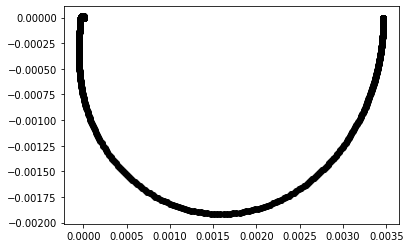

In [91]:
# Formulate optimization objective:
# maximize admittance 
# s.t.:
p0 =  [5, 120, 400, 100] # numerical value of params
x0 =  [0.01, 12,  500,  0.01, 10, 12, 10]  # initial guess at dec vars
vars0 = [*p0, *x0]
ubx = [0.06, 30, 3000, 10.0,  60, 40, 60]  # upper bound
lbx = [0.0,   5,  100,  0.0, 0.0, 0.0, 0.0]# lower bound
noise_bound_f = 10e-3 # 1e-3 is more realistic, but let's see
noise_bound_x = 1e-2 # 1e-3 is more realistic, but let's see
M_en = 12.0        # Env mass in Kg

# OBJECTIVE: J will be minimized, to maximize admittance F->v
#Am, Bm, Cm = tf2ss(G_num, G_den)
J = -(G).h2_norm(sol='csparse') #H2_norm(Am, Bm, Cm)

# Scale the objective
J_fn = ca.Function('J_fn', [*vars], [J])
J0 = J_fn(*p0, *x0)
J *= 1/ca.fabs(J0)
J_grad_fn = ca.Function('J_grad_fn', [*vars], [ca.gradient(J, ca.horzcat(*x))])
print('Objective: {}'.format(J0))
print('Gradient:  {}'.format(J_grad_fn(*p0, *x0)))
print('Noise fn:  {}'.format(nf_norm_fn(1e5, M_en, *p0, *x0)))

# CONSTRAINTS
g = []
ubg = []
lbg = []

# OL Stability:
rt = instab(Gd.den)
for r_i in range(1, len(rt)):
    g.append(rt[r_i]*rt[0])
    ubg.append(np.Inf)
    lbg.append(1e-8) 

    
# Stability and noise in contact:
for K_en in [3e5, 5e6]:
    #Stab
    G_cl_den = G_cl_den_fn(K_en, M_en, *vars)
    rt = instab(G_cl_den)
    for r_i in range(1, len(rt)):
        g.append(rt[r_i]*rt[0])
        ubg.append(np.Inf)
        lbg.append(1e-8)    

    #Noise
    g.append(nf_norm_fn(K_en, M_en, *vars))
    ubg.append(noise_bound_x)
    lbg.append(-np.Inf)
    
g.append(G_nx.h2_norm())
ubg.append(noise_bound_x)
lbg.append(-np.Inf)


for om in np.logspace(0.1, 4, num = 50):
    imag_pt = Gd_imag(om, *p0, *x)
    g.append(imag_pt)
    lbg.append(-0.5e-4)
    ubg.append(np.Inf)
    
    
opts = { 
         'ipopt.mu_strategy': 'monotone',        # Determines which barrier parameter update strategy is to be used. Default "monotone", can choose 'adaptive' instead
         'ipopt.mu_init' : 0.001,                # This option determines the initial value for the barrier parameter (mu). It is only relevant in the monotone, Fiacco-McCormick version of the algorithm.
       }
        
# J is objective, w decision vars, g constraints (subject to ubg and lbg)
prob = dict(f = J, x = ca.vertcat(*x), g = ca.vertcat(*g), p = ca.vertcat(*p))
solver = ca.nlpsol('solver', 'ipopt', prob, opts)
args = dict(x0 = x0, lbx = lbx, ubx = ubx, ubg = ubg, lbg = lbg, p = p0)
sol = solver(**args)
print(x0)
print(x_names)
print(sol['x'].full())
Gd.nyquist(vars, [*p0, *sol['x'].full()])

In [ ]:
# Find extrema of imaginary component over frequency
imag_der = der(imag_coeff)
print(imag_coeff)
poly_coeffs = ca.SX.sym('poly',3,1)
poly_coeffs[0] = imag_der[0]
poly_coeffs[1] = imag_der[2]
poly_coeffs[2] = imag_der[4]
roots = ca.sqrt(-ca.poly_roots(poly_coeffs))
print(roots[0])

for j in range(roots.shape[0]):
    tot = 0.0
    num_coeffs = len(imag_coeff)
    for i in range(num_coeffs):
        tot += ca.constpow(roots[j],num_coeffs-i-1)*imag_coeff[i]
    print(tot)
crit_points_imag = []
crit_points_real = []
crit_points_freq = []
for i in range(roots.shape[0]):
    crit_points_freq.append(ca.Function('crit_freq', [M, B, Kp, Kd, Ma, Ba, Kl], [roots[i]]))
    crit_points_imag.append(ca.Function('crit_imag', [M, B, Kp, Kd, Ma, Ba, Kl], [imag_fn(roots[i], M, B, Kp, Kd, Ma, Ba, Kl)]))
    crit_points_real.append(ca.Function('crit_real', [M, B, Kp, Kd, Ma, Ba, Kl], [real_fn(roots[i], M, B, Kp, Kd, Ma, Ba, Kl)]))

# Verifying the real/imaginary components are realistic
# Can compare with addmittance_check_casadi.m
import numpy as np
import matplotlib.pyplot as plt
Mt = 5
Bt = 10
Kpt = 1
Kdt = 2
Mat = 3
Bat = 5
Klt = 0.1

plt.figure()
plt.clf()
for om in [0.001, 10, 500]:
    print("freq {} real {} im {}".format(om, real_fn(om, Mt, Bt, Kpt, Kdt, Mat, Bat, Klt), imag_fn(om, Mt, Bt, Kpt, Kdt, Mat, Bat, Klt)))

for om in np.logspace(-10,10, num = 1000):
    plt.plot(real_fn(om, Mt, Bt, Kpt, Kdt, Mat, Bat, Klt), imag_fn(om, Mt, Bt, Kpt, Kdt, Mat, Bat, Klt),'ko')
    
for cp_r, cp_i, cp_f in zip(crit_points_real, crit_points_imag, crit_points_freq):
    print('crit point re: {} im: {} fr: {}'.format(\
                        cp_r(Mt, Bt, Kpt, Kdt, Mat, Bat, Klt), 
                        cp_i(Mt, Bt, Kpt, Kdt, Mat, Bat, Klt),
                        cp_f(Mt, Bt, Kpt, Kdt, Mat, Bat, Klt)))
    plt.plot(cp_r(Mt, Bt, Kpt, Kdt, Mat, Bat, Klt), cp_i(Mt, Bt, Kpt, Kdt, Mat, Bat, Klt),'dr')
plt.show()

In [ ]:
# TEST FUNCTIONS
# Test instap
#RT_col = instab([1, 2, 3, 4, 5])
#print(RT_col)

# Test lyap
A = np.array([[-0.1, 0, 1],[0, 1, 0], [0, 0, 1]])
Q = np.array([[1, 0, 0],[0, 1, 0], [0, 3, 1]])
X = lyap(A,Q)
print(X)

# Test H2
A = np.array([[-0.5, 1],[-0.2, -0.1]])
B = np.array([[0],[.3]])
C = np.array([[3, 0]])
print(H2_norm(A, B, C))

# Test tf2ss
num = [1, 3]
den = [1, 5, 10, 20, 20]
A, B, C = tf2ss(num, den)
print(H2_norm(A, B, C))

# Test symbolic diff
b = ca.MX.sym('b')
k = ca.MX.sym('k')
A = ca.MX.zeros(2,2)
A[0,1] = ca.MX(1.0)
A[1,0] = -b
A[1,1] = -k
#Q = ca.MX.eye(2)
norm = H2_norm(A, B, C)
norm_fn = ca.Function('norm', [b, k], [norm])
b_grad_fn = ca.Function('b_grad',[b, k], [ca.gradient(norm,b)])
k_grad_fn = ca.Function('k_grad',[b, k], [ca.gradient(norm,k)])

b0 = 2
k0 = 1.0
h = 0.1
h20 = norm_fn(b0, k0)
bgrad = b_grad_fn(b0, k0)
kgrad = k_grad_fn(b0, k0)
h21 = norm_fn(b0, k0+h*bgrad+h*kgrad)


print('H2 init: {}'.format(h20))
print('Grads:   {}, {}'.format(bgrad, kgrad))
print('H2 fin:  {}'.format(h21))
print('err:     {}'.format(h20+h*bgrad+h*kgrad-h21))

In [ ]:
# OLD: using casadi built-ins
# Build the functions for real/imaginary components of TF
from copy import deepcopy
num = R_num*D_num*Cff_num*A_num
den = R_den*D_den*Cff_den*A_den
# Building the complex conjugate
den_cc_coeff = ca.poly_coeff(den, s)
for i in range(1, den_cc_coeff.shape[0]):
    if i % 2 == 1: # odd power of 's' 
        den_cc_coeff[-i-1] = -den_cc_coeff[-i-1]
den_cc_poly = ca.polyval(den_cc_coeff, s)

# multiply num and den by complex conjugate
num_cc = num*den_cc_poly
den_cc = den*den_cc_poly

# Substitute s = j\omega (turn those j^2, j^4,... into -1s)
num_coeff = ca.poly_coeff(num_cc, s)
den_coeff = ca.poly_coeff(den_cc, s)

for i in range(0, num_coeff.shape[0]): # start at 1 to skip the 0th power of j\omega
    number_of_i_squared = ca.floor(i/2)
    if number_of_i_squared % 2 == 1:   # odd number of i^2 -> -1
        num_coeff[-i-1] *= -1.0
for i in range(0, den_coeff.shape[0]):
    num_i_squared = ca.floor(i/2)
    if num_i_squared % 2 == 1: # odd number of i^2 -> -1
        den_coeff[-i-1] *= -1.0

imag_coeff = deepcopy(num_coeff)
real_coeff = deepcopy(num_coeff)
for i in range(num_coeff.shape[0]):
    if i % 2 == 0: # even power of 's', 
        imag_coeff[-i-1] = 0
    else:
        real_coeff[-i-1] = 0
imag_poly = ca.polyval(imag_coeff,s)
real_poly = ca.polyval(real_coeff,s)
den_poly = ca.polyval(den_coeff,s)
imag_fn = ca.Function('imag_fn', [s, M, B, Kp, Kd, Ma, Ba, Ka], [imag_poly/den_poly])
real_fn = ca.Function('real_fn', [s, M, B, Kp, Kd, Ma, Ba, Ka], [real_poly/den_poly])
